Large Language Models Tutorial
======

This is the tutorial of the 2025 [Mediteranean Machine Learning Summer School](https://www.m2lschool.org) on Large Language Models!

This tutorial will explore the fundamental aspects of Large Language Models (LLMs). Basic Python programming skils are expected. Prior knowledge of standard NLP techniques (e.g. text tokenization) is beneficial but optional when working through the notebooks as they assume minimal prior knowledge.

This tutorial combines detailed analysis and development of essential LLM concepts via custom (i.e. from scratch) implementations. Other necessary LLM components will be developed using PyTorch. As a result, the tutorial offers deep understanding of LLMs and facilitates easy usage in future applications.

## Outline

Part I (**beginner**): Transformer Architecture
* Tokenization
* Positional Encoding
* Layers: Feed-forward, Multi-head Attention
* Transformer Model
* Training

Part II (**intermediate**): Mixture of Experts & Optimizations
* Mixture of Experts architecture
* KV cache
* Attention variants (Multi-Query, Group-Query Attention)
* Speculative decoding

Part III (**advanced**): Fine-tuning and RAG:
* Parameter Efficient Fine-tuning
* LoRA
* Quantized LoRA
* Retrieval-Augmented Generation (RAG)

## Notation

* Sections marked with [📚] contain cells that you should read and modify to understand how your changes alter the obtained results.
* Sections marked with [✍] contain cells with missing code that you should complete.
* Sections marked with [⚙️] contain code that tests the functionality of other sections. You can modify these sections to understand the code functionality.
* External resources are marked with [✨]. These provide supplementary information and offer opportunities for further in-depth exploration of the topics covered.

## Libraries

This tutorial leverages [PyTorch](https://pytorch.org) for neural networks implementation and training, complemeted by standard Python libraries for data processing and the [Hugging Face](https://huggingface.co/) datasets library for accessing NLP resources.

GPU access is recommended for optimal performance, particularly for model training and text generation. While all code can run on CPU, a CUDA-enabled environment will significantly speed up these processes.

## Credits

The tutorial is created by:

* [Aleksandar Stanic](https://astanic.github.io/)
* [Mandana Samiei](https://linclab.mila.quebec/team/mandana)

It is inspired by and synthesizes various online resources (including the [M2L2024 NLP tutorial](https://github.com/M2Lschool/tutorials2024/tree/main/1_nlp)), which are cited throught for reference and further reading.

## Note for Colab users

To grab a GPU (if available), go to `Edit -> Notebook settings` and choose a GPU (T4) under `Hardware accelerator`.

# Part III: Introduction to Parameter Efficient Fine-tuning

We show how a model that has been pre-trained on a lot of data can be adapted to be used in a downstream task by fine-tuning it on a target dataset.
* The first approach would be adapting all weights of the network (traditional supervised fine-tuning (SFT)), but this can be resource intensive.
* Secondly, we could freeze weights of all but the last layer. This results in faster training, but also in worse performance on our target task.
* Thirdly, we introduce Parameter Efficient Fine-Tuning (PEFT) and one approach in that family, LoRA, that improves the performance while being less resource intensive.
* Finally, we introduce Quantization-aware training with 4-bit quantization and QLorA, which further speed up the training.

# Definitions and utils

## Step 1: Import libraries


In [ ]:
!pip install datasets peft==0.12 evaluate
!pip install -U bitsandbytes

import math
import torch
import torch.nn as nn

from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig
from transformers.utils import PushToHubMixin

from peft.tuners.lora.layer import dispatch_default, Linear
from peft.tuners.tuners_utils import BaseTunerLayer
from peft import LoraConfig, PeftModel, LoraModel, get_peft_model
from datasets import load_dataset

import numpy as np
import evaluate
from transformers import TrainingArguments, Trainer

We will fine-tune the ✨ [BERT](https://arxiv.org/pdf/1810.04805) architecture, a well known language classification architecture built based on the Transformer model.
The pre-trained model is available at different sources.
We will use HuggingFace library, since it has become a standard for LLMs and it includes a large number of conenient tools for language processing and generation.

In [ ]:
model_name_or_path = "google-bert/bert-base-cased"
tokenizer_name_or_path = "google-bert/bert-base-cased"

## ✍ Step 2: Load Dataset

Let's pick a dataset and use the tokenizer that corresponds to the BERT model.
The ✨ [Yelp reviews dataset](https://huggingface.co/datasets/Yelp/yelp_review_full) consists of reviews from Yelp. Each review has a number of stars (between one and five).
The neural network gets a review at the input, and needs to predict the number of stars for that review.


In [ ]:
# Load the yelp_review_full dataset using load_dataset
dataset = load_dataset("yelp_review_full")

dataset["train"] = dataset["train"].shuffle(seed=42).select(range(1000))
dataset["test"] = dataset["test"].shuffle(seed=42).select(range(1000))

In [ ]:
# Load the BERT tokenizer with AutoTokenizer
tokenizer = TODO

def tokenizer_function(examples):
    # Par to max length and truncate sentences
    return tokenizer(examples["text"], TODO

# Apply the tokenizer function to the entire dataset
tokenized_datasets = dataset.map(tokenizer_function, batched=True)
small_train_dataset  = tokenized_datasets["train"]
small_eval_dataset = tokenized_datasets["test"]

## ✍ Step 3: Define Training and Evaluation Loop

Let's standardize the training and evaluation loop, so we can better see the difference in the final result between the three finetuning techniques explained.

We also introduce a utils function to count the nummber of trainable parameters in FT each case.

In [ ]:
def train_and_evaluate(model, max_steps=-1, num_train_epochs=2, learning_rate=5e-5):
    metric = evaluate.load("accuracy")

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        # The greedy prediction is the argmax of the logits
        predidictions = TODO
        return metric.compute(predictions=predictions, references=labels)

    training_args = TrainingArguments(
        output_dir="test_trainer",
        num_train_epochs=num_train_epochs,
        max_steps=max_steps,
        learning_rate=learning_rate,
        label_names=["labels"],
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_train_dataset,
        eval_dataset=small_eval_dataset,
        compute_metrics=compute_metrics,
    )

    train_metrics = trainer.train()
    print("[train]", train_metrics)
    eval_metrics = trainer.evaluate()
    print("[eval]", eval_metrics)


def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable: {100 * trainable_params / all_param:.2f}%"
    )


# Fine-tuning methods

## ✍ Step 1: Full fine-tuning

The simplest possibility is to fine-tune all parameters in the pre-trained BERT model, but also the new linear classifier on top.
This may achieve the best final accuracy (unless we overfit to the new dataset), but it results in slow fine-tuning.


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels=5)
print_trainable_parameters(model)


In [ ]:
# Explore learning rates in the set [5e-2, 5e-3, 5e-4, 5e-5] to find the best one with this configuration.
train_and_evaluate(model, learning_rate=TODO)

## ✍ Step 2: Head fine-tuning

Another possibility is to fix the weights of the pre-trained BERT, and fine-tune only the "head".
This is the linear classifier that HuggingFace code placed on top of the BERT model when we set `num_labels=5`.
This will drastically reduce the number of trainable parameters, and therefore significantly speed up fine-tuning.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels=5)

# Set as trainable only the parameters of the classifier layer (parameters whose name starts with `classifier`)
for name, param in model.named_parameters():
    ###############################################################
    # TODO
    ###############################################################

print_trainable_parameters(model)

In [ ]:
# Explore learning rates in the set [5e-2, 5e-3, 5e-4, 5e-5] to find the best one with this configuration.
train_and_evaluate(model, learning_rate=TODO)

## 📚 Step 3: LoRA Finetuning

Parameter Efficient Fine-Tuning (PEFT) reduces the number of parameters to fine-tune, while still achieving good performance.
One of the most popular PEFT methods is ✨ [Low-Rank adaptation of Language Models (LoRA)](https://arxiv.org/pdf/2106.09685).
It consists of constructing the new matrices as $\theta = \widehat{\theta} + A^TB$, where $\theta\in\mathbb{R}^{N\times N}$ is the new matrix of our model, the pre-trained weights $\widehat{\theta}\in\mathbb{R}^{N\times N}$ are kept fixed, and only an additive component made up by multiplying two smaller matrices $A,B\in\mathbb{R}^{r\times N}$ is learned. The result of their multiplication $A^TB\in\mathbb{R}^{N\times N}$ is a low-rank matrix.
This drastically reduces the number of parameters to train, if $A$ and $B$ are chosen appropriately.

<img src="https://heidloff.net/assets/img/2023/08/lora.png" alt="drawing" width="50%"/>

The speed up is noticeable with BERT, and becomes more significant for larger models.

#### ✨ References
- [LORA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/pdf/2106.09685)
- [DoRA: Weight-Decomposed Low-Rank Adaptation](https://arxiv.org/pdf/2402.09353)
- [HuggingFace PEFT Tutorial](https://huggingface.co/blog/peft)
- [HuggingFace PEFT Tutorial for image classification](https://huggingface.co/docs/peft/main/en/task_guides/image_classification_lora)
- [HuggingFace Training Tutorial](https://huggingface.co/docs/transformers/training)



In [ ]:
# Define LoRA hyper-parameters

peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)

In [ ]:
# Define a custom LoRA layer

class CustomLinearLoRA(Linear):
    def update_layer(
            self,
            adapter_name,
            r,
            lora_alpha,
            lora_dropout,
            init_lora_weights,
            use_rslora=False,
            use_dora=False,
    ):
        # This code works for linear layers, override it for other layer types
        if r <= 0:
            raise ValueError(f"`r` should be a positive integer value but got {r}")

        self.r[adapter_name] = r
        self.lora_alpha[adapter_name] = lora_alpha

        # Define a dropout layer
        lora_dropout_layer = TODO
        self.lora_dropout.update(nn.ModuleDict({adapter_name: lora_dropout_layer}))

        # Trainable parameters
        # Linear layer from self.in_features to r
        self.lora_A[adapter_name] = TODO
        # Linear layer from r to self.out_features
        self.lora_B[adapter_name] = TODO

        self.scaling[adapter_name] = lora_alpha / r

        self.reset_lora_parameters(adapter_name, init_lora_weights)
        self.set_adapter(self.active_adapters)

    def forward(self, x, *args, **kwargs):
        result = self.base_layer(x, *args, **kwargs)
        torch_result_dtype = result.dtype
        for adapter in self.active_adapters:
            if adapter not in self.lora_A.keys():
                continue
            lora_A = self.lora_A[adapter]
            lora_B = self.lora_B[adapter]
            dropout = self.lora_dropout[adapter]
            scaling = self.scaling[adapter]

            x = x.to(lora_A.weight.dtype)
            x = dropout(x)

            # Add to the result of the base layer the output of
            # lora_B and lora_A and multiply by the scaling factor
            result = result + TODO
        result = result.to(torch_result_dtype)
        return result


Since we are using the HuggingFace PEFT library, we need to tweak some of its internal workings to be able to expose our custom LoRA layer. Therefore the following cell is not very insightful and you can ignore it.

In [ ]:
def custom_dispatch_default(target: torch.nn.Module, adapter_name, lora_config, **kwargs):
    new_module = None
    target_base_layer = target.get_base_layer() if isinstance(target, BaseTunerLayer) else target

    if isinstance(target_base_layer, torch.nn.Linear):
        kwargs.update(lora_config.loftq_config)
        new_module = CustomLinearLoRA(target, adapter_name, **kwargs)

    if new_module is None:
        new_module = dispatch_default(target, adapter_name, lora_config=lora_config, **kwargs)
    return new_module

class CustomLoraModel(LoraModel):
    @staticmethod
    def _create_new_module(lora_config, adapter_name, target, **kwargs):
        return custom_dispatch_default(target, adapter_name, lora_config=lora_config, **kwargs)

class CustomPeftModel(PeftModel):
    def __init__(self, model, peft_config, adapter_name="default"):
        PushToHubMixin.__init__(self)
        torch.nn.Module.__init__(self)

        # self.modules_to_save = None
        self.active_adapter = adapter_name
        self.peft_type = peft_config.peft_type
        # These args are special PEFT arguments that users can pass.
        # They need to be removed before passing them to forward.
        self.special_peft_forward_args = {"adapter_names"}

        self._is_prompt_learning = peft_config.is_prompt_learning
        self._peft_config = None
        self.base_model = CustomLoraModel(model, {adapter_name: peft_config}, adapter_name)

        self.set_additional_trainable_modules(peft_config, adapter_name)

        if getattr(model, "is_gradient_checkpointing", True):
            model = self._prepare_model_for_gradient_checkpointing(model)

        # `pretraining_tp` is set for some models to simulate Tensor Parallelism
        # during inference to avoid numerical differences (https://github.com/pytorch/pytorch/issues/76232).
        # To avoid any unexpected behavior we disable that in this line.
        if hasattr(self.base_model, "config") and hasattr(self.base_model.config, "pretraining_tp"):
            self.base_model.config.pretraining_tp = 1

Now we have everything we need to fine-tune BERT with LoRA. We load again the model, we upgrade it with LoRA, we count the trainable parameters and let's see what happens when we fine-tune it.

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path, num_labels=5)

model = CustomPeftModel(model, peft_config)
print_trainable_parameters(model)

In [ ]:
# Explore learning rates in the set [5e-2, 5e-3, 5e-4, 5e-5] to find the best one with this configuration
train_and_evaluate(model, learning_rate=TODO)

As you see, LoRA was faster than full fine-tuning, with a better final performance than just updating the last linear layer.

## 📚 Step 4: Quantization-aware Training

Idea: Speed things up by reducing the precision of numbers. In this way we can speed up both training and inference. Less memory means higher latency (since inference is memory limited). Also requires fewer FLOPs.



Number formats:

1. float32: 1 sign 8 exponent 23 mantissa
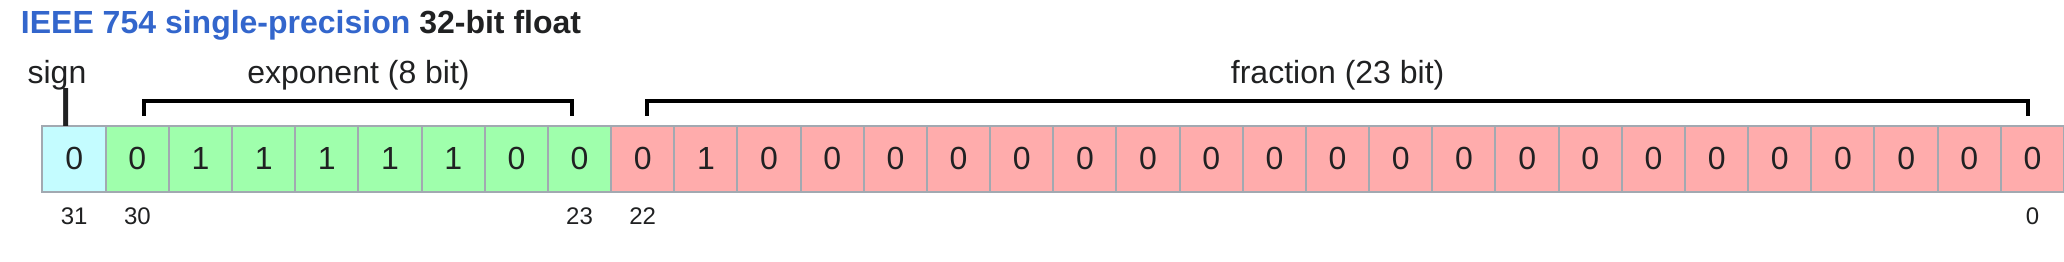
2. float16: 1 sign 5 exponent 10 mantissa
3. bfloat16: 1 sign 8 exponent 7 mantissa
4. float8 E4M3/E5M2: 1 sign 4 (or 5) exponent 3 (or 2) mantissa (H100s support both)

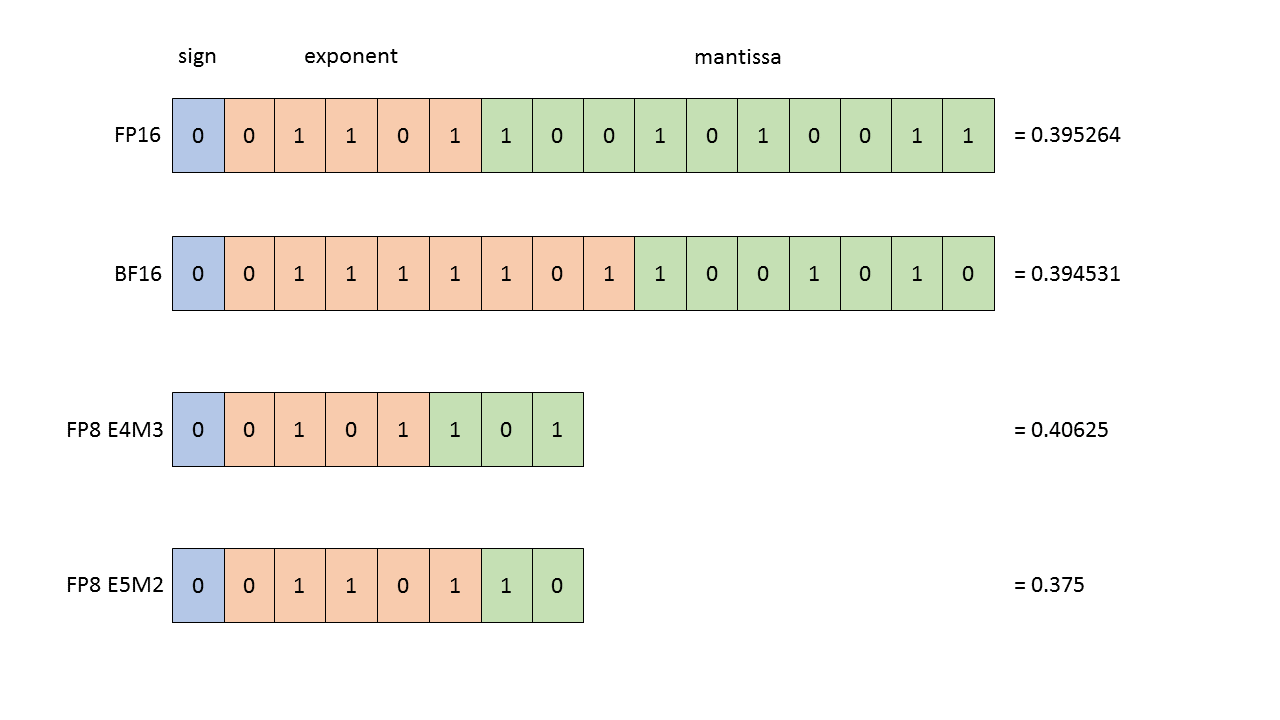



✨ [Using FP8 with Transformer Engine](https://docs.nvidia.com/deeplearning/transformer-engine/user-guide/examples/fp8_primer.html)

✨ [FP8: Efficient model inference with 8-bit floating point numbers](https://www.baseten.co/blog/fp8-efficient-model-inference-with-8-bit-floating-point-numbers/#an-introduction-to-floating-point-numbers)



On the flip side, we have to worry about accuracy, so in general we need to be careful which parts of the network/activations we quantize. General rules of thumb:
* fp32 (4 bytes): needed for parameters and optimizer states during training
* bf16 (2 bytes): default for inference

Here we go even more extreme by running training with 4-bit quantization and QLoRA.

✨ [QLORA: Efficient Finetuning of Quantized LLMs](https://arxiv.org/abs/2305.14314)

✨ [Making LLMs even more accessible with bitsandbytes, 4-bit quantization and QLoRA](https://huggingface.co/blog/4bit-transformers-bitsandbytes)

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)


model = AutoModelForSequenceClassification.from_pretrained(
    model_name_or_path,
    num_labels=5,
    quantization_config=quantization_config,
    device_map="auto"
)

peft_config_qlora = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS",
    target_modules=[
        "query",
        "value",
    ],
)

model = get_peft_model(model, peft_config_qlora)


In [ ]:
print("Trainable parameters for QLoRA:")
print_trainable_parameters(model)

In [ ]:
train_and_evaluate(model, learning_rate=TODO)

# RAG (Retrieval-Augmented Generation)

- Retrieves relevant documents from a corpus (using a retriever like FAISS or DPR),

- Generates an answer conditioned on both the query and retrieved documents (usually with a seq2seq model like facebook/rag-token-base or t5-base).

It's most useful in tasks like:

- Open-domain QA (e.g., "Who discovered gravity?")

- Knowledge-grounded generation

## Step 1: Install Required Libraries


In [ ]:
!pip install -q torch transformers sentence-transformers langchain faiss-cpu datasets
!pip install -U langchain-community

## Step 2: Load and Prepare Your Knowledge Base

In [ ]:
from datasets import load_dataset
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from tqdm.auto import tqdm

# Load a dataset—for example, HuggingFace documentation
ds = load_dataset("m-ric/huggingface_doc", split="train")

# Convert to LangChain Documents
docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

# Split documents into smaller, semantically coherent chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=100,
    separators=["\n\n", "\n", ".", " ", ""]
)
chunks = text_splitter.split_documents(docs)


##Step 3: Build a Vector Store & Retriever

In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

# Use a sentence-transformers embedding model for chunk encoding
embed_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Build a FAISS index from the chunks
vector_store = FAISS.from_documents(chunks, embed_model)

# Define a retriever
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})


## Step 4: Plug into an LLM for Answer Generation

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

# Load a generation model (e.g., T5 variant)
tokenizer = AutoTokenizer.from_pretrained("t5-small")
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")

def rag_answer(question: str, use_rag: bool):
    # Retrieve relevant chunks
    if use_rag:
        retrieved_docs = retriever.get_relevant_documents(question)
        context = "\n---\n".join([doc.page_content for doc in retrieved_docs])
        input_text = f"question: {question}  context: {context}"
    else:
        input_text = f"question: {question}"

    # Generate an answer
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=512)
    outputs = model.generate(**inputs, max_length=200)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Non-RAG answer
question = "What is HF docs?"
non_rag_response = rag_answer(question, use_rag=False)
rag_response = rag_answer(question, use_rag=True)

print('-'*89)
print("Non-RAG answer:")
print(non_rag_response)
print('-'*89)
print("RAG answer:")
print(rag_response)


# Congratulations!

    \o/   🎉
     |       CONGRATS!
    / \      You did it 🎓 You are done with the third part of the tutorial.

